![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Exercise material of the MSc-level course **Advanced Soil Mechanics**.
Held at Technische Universität Bergakademie Freiberg.

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/fakultaet3/gt/soilmechanics

# Stresses under foundations

A strip foundation of width 15 m is loaded with 1000 kPa. We investigate the cases of a soft and a rigid loading on the stress and displacement fields. The simulations are run with the open-source software OpenGeoSys 6. For now, only elastic material laws are used.

In [14]:
#HIDDEN
from ogs6py.ogs import OGS
import vtuIO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.tri as tri

import plot_settings

In [15]:
geo_static=OGS(INPUT_FILE="tonlinse-gravity-nonequilibrium_stress.prj", PROJECT_FILE="geostatic_3m.prj")
soft_load=OGS(INPUT_FILE="tonlinse-gravity-nonequilibrium_stress.prj", PROJECT_FILE="soft_load_3m.prj")
rigid_load=OGS(INPUT_FILE="tonlinse-gravity-nonequilibrium_stress.prj", PROJECT_FILE="rigid_load_3m.prj")

We first calculate the response to geostatic loading. So the top load is set to zero, only gravity acts.

In [16]:
geo_static.replace_parameter(name="p_inTop",   value=0)
geo_static.replace_text("geo_static_3m_output", xpath="./time_loop/output/prefix")
geo_static.write_input()

True

In the soft case, we apply a traction boundary condition along the width of the foundation element.

In [17]:
soft_load.replace_parameter(name="p_inTop",   value=-1000.e3)
soft_load.replace_parameter(name="E2",   value=300.e6)
soft_load.replace_text("soft_load_3m_output", xpath="./time_loop/output/prefix")
soft_load.write_input()

True

In the rigid case, we apply a vertical displacement as a boundary condition along the width of the foundation element such that displacements in the characteristic point of the foundation elements are equivalent.

In [18]:
rigid_load.replace_parameter(name="p_inTop",   value=-1000.e3)
rigid_load.replace_parameter(name="E2",   value=30.e11)
rigid_load.replace_text("rigid_load_3m_output", xpath="./time_loop/output/prefix")
rigid_load.write_input()

True

Now let's run all models.

In [19]:
PATH_OGS="~/ogs_release/bin/"
geo_static.run_model(path=PATH_OGS)

OGS finished with project file geostatic_3m.prj.
Execution took 0.23929738998413086 s


In [20]:
soft_load.run_model(path=PATH_OGS)

OGS finished with project file soft_load_3m.prj.
Execution took 0.28438472747802734 s


In [21]:
rigid_load.run_model(path=PATH_OGS)

OGS finished with project file rigid_load_3m.prj.
Execution took 0.3398725986480713 s


We now study the output along horizontal lines at various depths.

In [22]:
pvd_geo = vtuIO.PVDIO(".","geo_static_3m_output.pvd",dim=2)
pvd_soft = vtuIO.PVDIO(".","soft_load_3m_output.pvd", dim=2)
pvd_rigid = vtuIO.PVDIO(".","rigid_load_3m_output.pvd", dim=2)

./geo_static_3m_output.pvd
./soft_load_3m_output.pvd
./rigid_load_3m_output.pvd


In [23]:
line_0=[(i,50.0,0) for i in np.linspace(start=20.0, stop=80.0, num=100)]
#line_2=[(i,48.0,0) for i in np.linspace(start=20.0, stop=80.0, num=100)]
line_4=[(i,46.0,0) for i in np.linspace(start=20.0, stop=80.0, num=100)]
line_8=[(i,42.0,0) for i in np.linspace(start=20.0, stop=80.0, num=100)]
line_15=[(i,35.0,0) for i in np.linspace(start=20.0, stop=80.0, num=100)]
line_25=[(i,25.0,0) for i in np.linspace(start=20.0, stop=80.0, num=100)]
lines = {#'2.0 m': line_2,
         '4.0 m': line_4,
         '8.0 m': line_8,
         '15.0 m': line_15,
         '25.0 m': line_25}

First, we look at the vertical normal stresses, both their total values and their increments. The soft foundation is shown in dashed lines, the rigid one in solid lines.

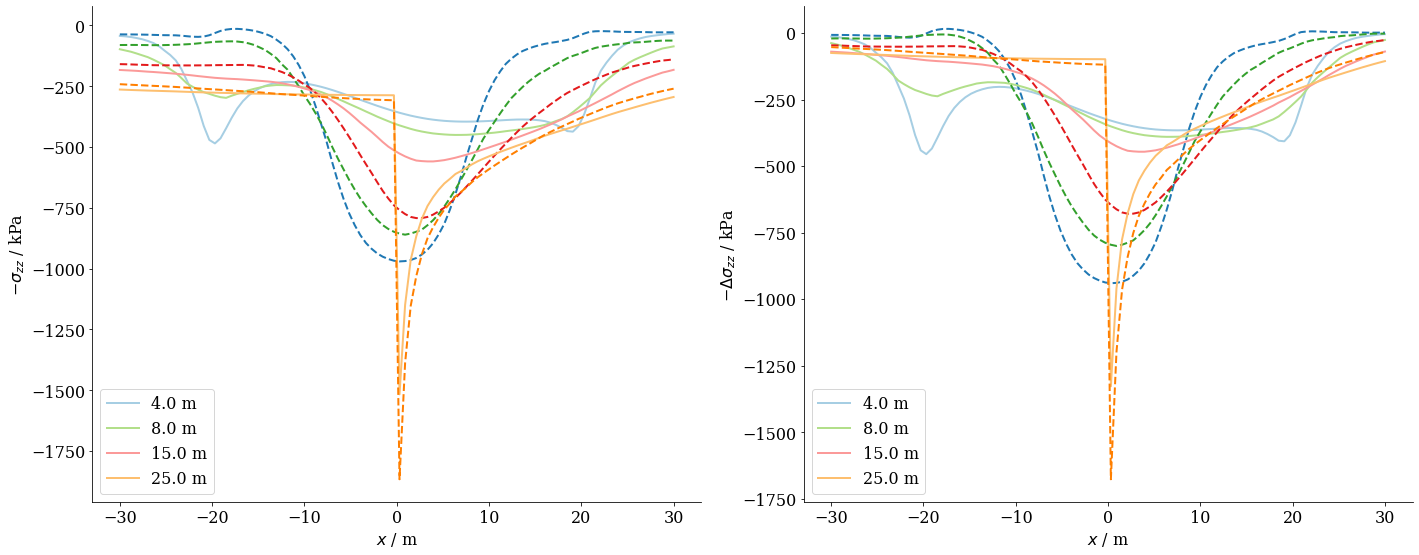

In [24]:
#HIDDEN
sns.set_palette("Paired",n_colors=10)
fig, ax = plt.subplots(ncols=2,figsize=(20,8))
x = np.linspace(20,80,100)
for i in lines:
    rigid = pvd_rigid.read_point_set_data(1,'sigma', pointsetarray=lines[i]).T[1]/1e3
    soft = pvd_soft.read_point_set_data(1,'sigma', pointsetarray=lines[i]).T[1]/1e3
    geo = pvd_geo.read_point_set_data(1,'sigma', pointsetarray=lines[i]).T[1]/1e3
    ax[0].plot(x-50,rigid, label=i,ls='-')
    ax[0].plot(x-50,soft,ls='--')
    ax[1].plot(x-50,rigid-geo, label=i,ls='-')
    ax[1].plot(x-50,soft-geo,ls='--')
ax[0].legend()
ax[0].set_xlabel('$x$ / m')
ax[0].set_ylabel('$-\\sigma_{zz}$ / kPa')
ax[1].legend()
ax[1].set_xlabel('$x$ / m')
ax[1].set_ylabel('$-\\Delta\\sigma_{zz}$ / kPa')
fig.tight_layout();

Finally, we wish to confirm that settlements in the characteristic points are indeed equivalent between both cases.

In [25]:
disp_rigid = pvd_rigid.read_point_set_data(1,'displacement', pointsetarray=line_0).T[1]*100
disp_soft = pvd_soft.read_point_set_data(1,'displacement', pointsetarray=line_0).T[1]*100
disp_geo = pvd_geo.read_point_set_data(1,'displacement', pointsetarray=line_0).T[1]*100

In [26]:
#x_K = 50-5*0.37
#u_K_soft = pvd_soft.read_point_set_data(1,'displacement',pointsetarray=[(x_K,50,0)]).T[1]*100
#u_K_rigid = pvd_rigid.read_point_set_data(1,'displacement',pointsetarray=[(x_K,50,0)]).T[1]*100
#u_K_geo = pvd_geo.read_point_set_data(1,'displacement',pointsetarray=[(x_K,50,0)]).T[1]*100

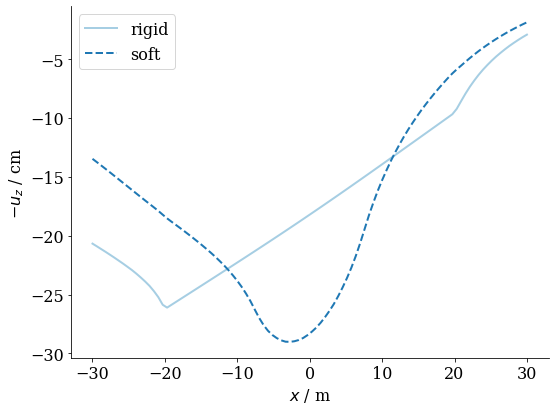

In [35]:
#HIDDEN
fig, ax = plt.subplots()
ax.plot(x-50,disp_rigid-disp_geo,label='rigid')
ax.plot(x-50,disp_soft-disp_geo,label='soft',ls='--')
#ax.plot(x_K-50,u_K_rigid-u_K_geo,marker='o')
#ax.plot(x_K-50,u_K_soft-u_K_geo,marker='x')
ax.legend()
ax.set_xlabel('$x$ / m')
ax.set_ylabel('$-u_z$ / cm')
fig.tight_layout();

In [28]:
print("Setzungsdifferenz im kennzeichnenden Punkt ist %.2f cm." 
      %(u_K_rigid - u_K_soft))

Setzungsdifferenz im kennzeichnenden Punkt ist 9.96 cm.


Now we look at the distribution of various fields. We start with the settlement fields.

In [29]:
m_soft=vtuIO.VTUIO("soft_load_3m_output_ts_1_t_1.000000.vtu",dim=2)
m_rigid=vtuIO.VTUIO("rigid_load_3m_output_ts_1_t_1.000000.vtu",dim=2)
m_geo=vtuIO.VTUIO("geo_static_3m_output_ts_1_t_1.000000.vtu",dim=2)

In [30]:
triang=tri.Triangulation(m_geo.points[:,0]-20,m_geo.points[:,1])

In [31]:
u_z_geo = m_geo.get_field("displacement").T[1] * 100
u_z_soft = m_soft.get_field("displacement").T[1] * 100
u_z_rigid = m_rigid.get_field("displacement").T[1] * 100

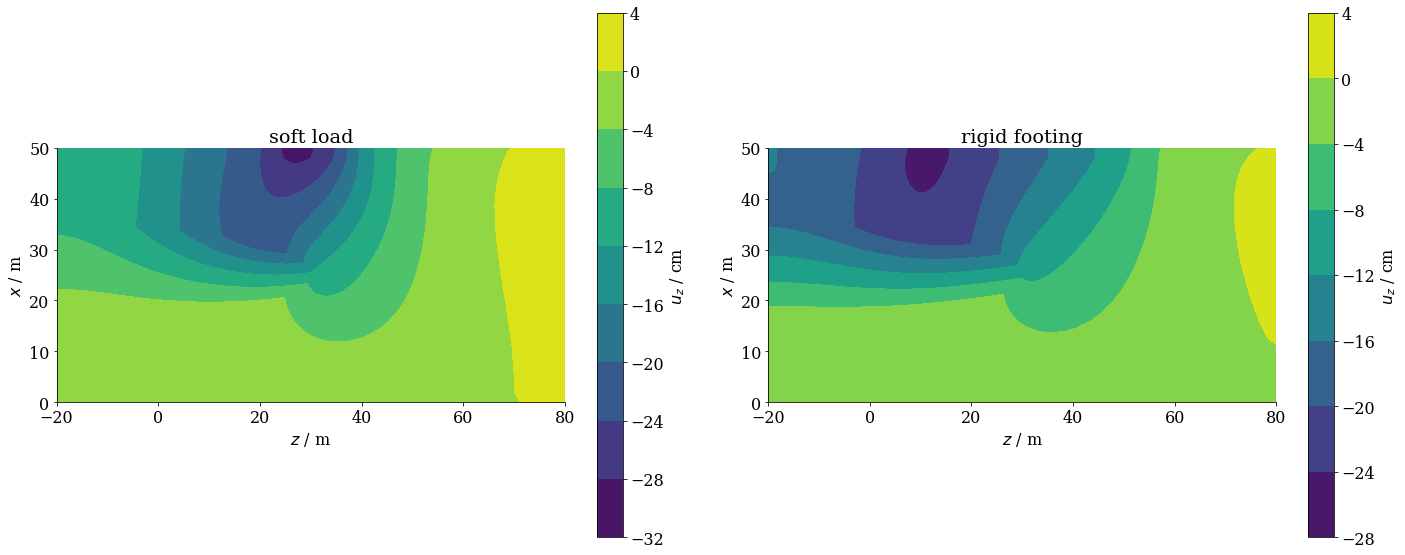

In [32]:
#HIDDEN
fig, ax = plt.subplots(ncols=2,figsize=(20,8))
contour_soft = ax[0].tricontourf(triang, u_z_soft-u_z_geo)
contour_rigid = ax[1].tricontourf(triang, u_z_rigid-u_z_geo)
fig.colorbar(contour_soft,ax=ax[0],label='$u_z$ / cm')
fig.colorbar(contour_rigid,ax=ax[1],label='$u_z$ / cm')
ax[0].set_title('soft load')
ax[1].set_title('rigid footing')
for i in range(2):
    ax[i].set_aspect('equal')
    ax[i].set_ylabel('$x$ / m')
    ax[i].set_xlabel('$z$ / m')
fig.tight_layout();

Next, we study the vertical normal stresses in the domain beneath the loads.

In [33]:
sig_zz_soft = m_soft.get_field("sigma").T[1] / 1000
sig_zz_rigid = m_rigid.get_field("sigma").T[1] / 1000

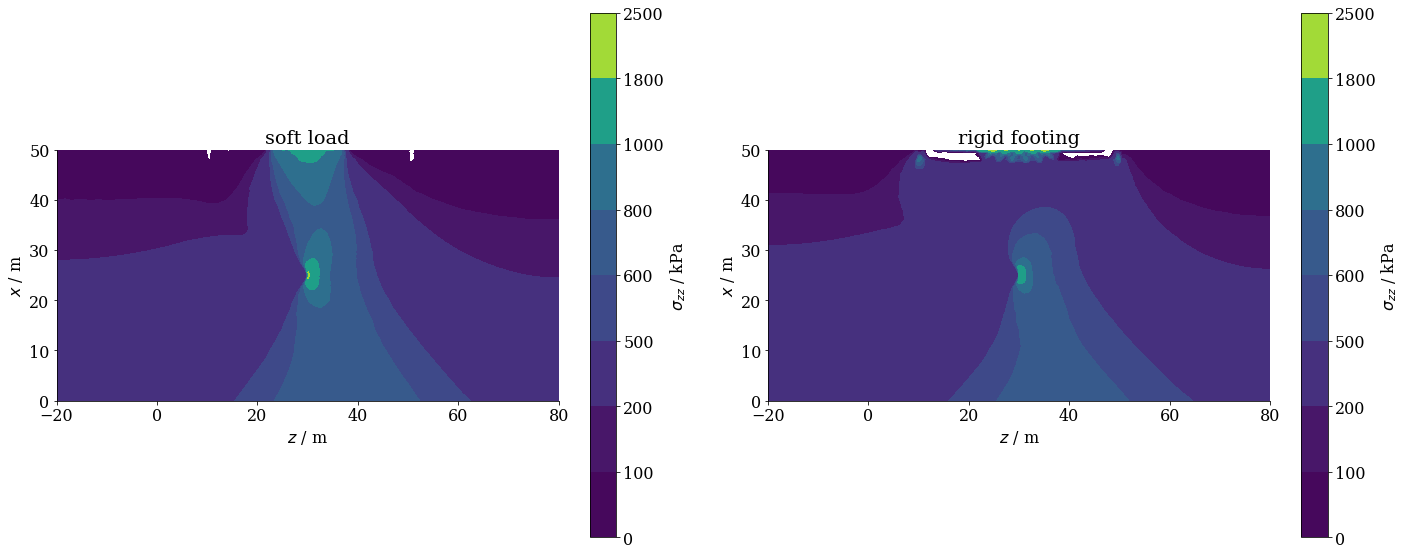

In [34]:
#HIDDEN
fig, ax = plt.subplots(ncols=2,figsize=(20,8))
contour_soft = ax[0].tricontourf(triang, -sig_zz_soft,levels=[0,100,200,500,600,800,1000,1800,2500])
contour_rigid = ax[1].tricontourf(triang, -sig_zz_rigid,levels=[0,100,200,500,600,800,1000,1800,2500])
fig.colorbar(contour_soft,ax=ax[0],label='$\\sigma_{zz}$ / kPa')
fig.colorbar(contour_rigid,ax=ax[1],label='$\\sigma_{zz}$ / kPa')
ax[0].set_title('soft load')
ax[1].set_title('rigid footing')
for i in range(2):
    ax[i].set_aspect('equal')
    ax[i].set_ylabel('$x$ / m')
    ax[i].set_xlabel('$z$ / m')
fig.tight_layout();